In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

%matplotlib widget

In [2]:
def gauss_detrend(time, flux):
    # Kernel that models only long-term variations (>= ~10 days)
    kernel = C(1.0) * RBF(length_scale=10.0, length_scale_bounds=(8.0, 20.0)) + WhiteKernel(noise_level=1e-4)

    base_alpha = 0.15
    alpha_per_point = base_alpha**2

    gp = GaussianProcessRegressor(kernel=kernel,
                                  alpha=alpha_per_point,
                                  normalize_y=True,
                                  optimizer=None)
    gp.fit(time[:, None], flux)

    long_term_trend = gp.predict(time[:, None])

    detrended = flux - long_term_trend

    return detrended, long_term_trend

def _model_gaussian(x, a, b, d):
    return a * np.exp(-0.5 * ( (x-d) / (b) )**2)
    
def inject_gaussian(times, magnitude, three_sigma_width, zp = 8.9):
    amplitude = _amplitude(magnitude, zp)
    position = np.random.uniform(min(times), max(times))
    sigma_width = three_sigma_width/3
    noise = np.random.normal(loc = 0, scale = 0.05, size = len(times))
    gaussian = _model_gaussian(times, amplitude, sigma_width, position)
    gaussian += noise
    return gaussian
    
def _amplitude(m, zp):
    return 10**((zp - m)/2.5) * 1e6
        

In [9]:
df = pd.read_csv('/Users/zgl12/Modules/SN2019vxm/Data/tess_sector_18_psf_calib_vxm.csv')
df = df[(df['MJD'] < 58801) & (df['MJD'] > 58792) | (df['MJD'] > 58802) & (df['MJD'] < 58812)]
df

flux = deepcopy(df.uJy.values)

gaussian = inject_gaussian(df.MJD.values, 18, 2, zp = 8.9)

flux += gaussian

In [10]:
smooth, _ = gauss_detrend(df.MJD.values, flux)

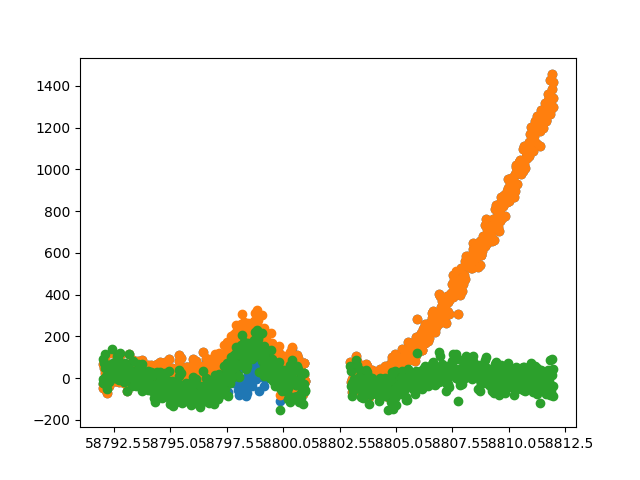

In [11]:
plt.figure()
plt.scatter(df.MJD.values, df.uJy.values)
plt.scatter(df.MJD.values, flux)
plt.scatter(df.MJD.values, smooth)
plt.show()